# 1. Install Dependencies and Setup

In [1]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
#!pip list

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
data_dir = 'G:/Ponti/'

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 445 files belonging to 4 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

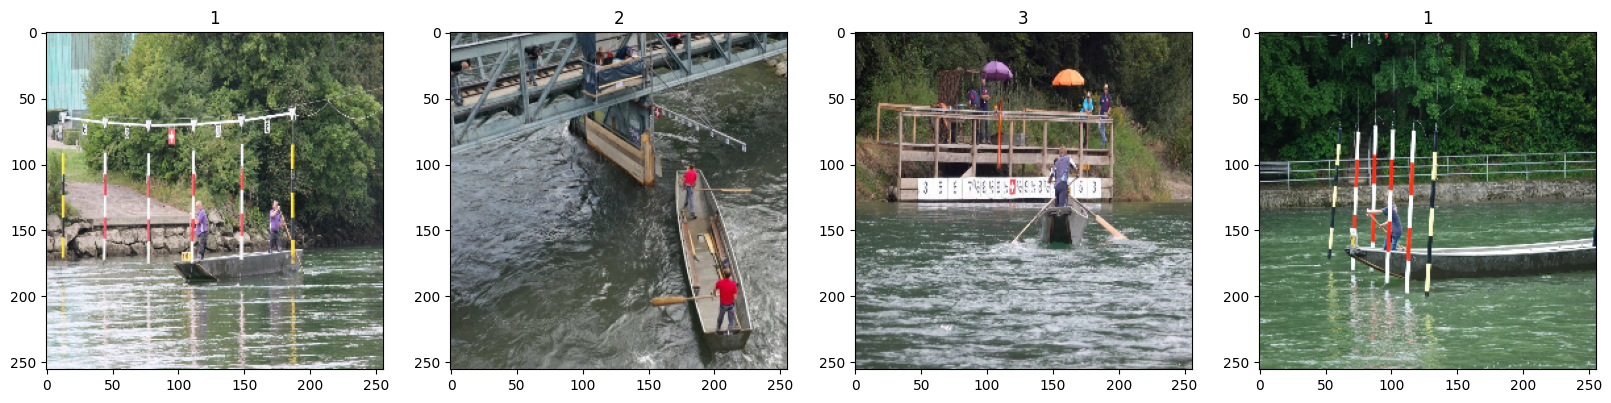

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[2.98998892e-01, 3.36828262e-01, 2.19405472e-01],
          [2.46993005e-01, 2.87000835e-01, 2.04054892e-01],
          [2.54322380e-01, 3.07386100e-01, 2.02300310e-01],
          ...,
          [2.28737742e-01, 2.76838243e-01, 2.57624120e-01],
          [1.67301193e-01, 2.10438445e-01, 2.26124719e-01],
          [1.68401018e-01, 2.17972100e-01, 2.21526027e-01]],
 
         [[2.25128174e-01, 2.59676099e-01, 1.92013726e-01],
          [1.95310339e-01, 2.32428938e-01, 1.83924541e-01],
          [1.97077498e-01, 2.46219650e-01, 1.58634558e-01],
          ...,
          [1.83293357e-01, 2.27034867e-01, 2.39381671e-01],
          [1.55453429e-01, 1.98590681e-01, 2.14276955e-01],
          [1.59586236e-01, 2.06455603e-01, 2.11810663e-01]],
 
         [[1.70581892e-01, 2.17640713e-01, 1.34920135e-01],
          [1.71947286e-01, 2.15084538e-01, 1.60182580e-01],
          [1.95213646e-01, 2.46194035e-01, 1.73331231e-01],
          ...,
          [1.49073467e-01, 1.94048956e-01, 2.3798

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

9

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 13s 1s/step - loss: -35.3508 - accuracy: 0.3438 - val_loss: -170.7517 - val_accuracy: 0.2500
Epoch 2/20
9/9 [==============================] - 12s 1s/step - loss: -731.8141 - accuracy: 0.3715 - val_loss: -2322.9148 - val_accuracy: 0.3281
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: -7623.1665 - accuracy: 0.3299 - val_loss: -18521.5078 - val_accuracy: 0.3906
Epoch 4/20
9/9 [==============================] - 12s 1s/step - loss: -42307.5820 - accuracy: 0.3090 - val_loss: -66318.8203 - val_accuracy: 0.4219
Epoch 5/20
9/9 [==============================] - 12s 1s/step - loss: -169740.7188 - accuracy: 0.3438 - val_loss: -400053.9375 - val_accuracy: 0.3125
Epoch 6/20
9/9 [==============================] - 12s 1s/step - loss: -500272.4375 - accuracy: 0.3681 - val_loss: -993481.2500 - val_accuracy: 0.2656
Epoch 7/20
9/9 [==============================] - 12s 1s/step - loss: -1488271.3750 - accuracy: 0.3368 - val_loss: -3

# 8. Plot Performance

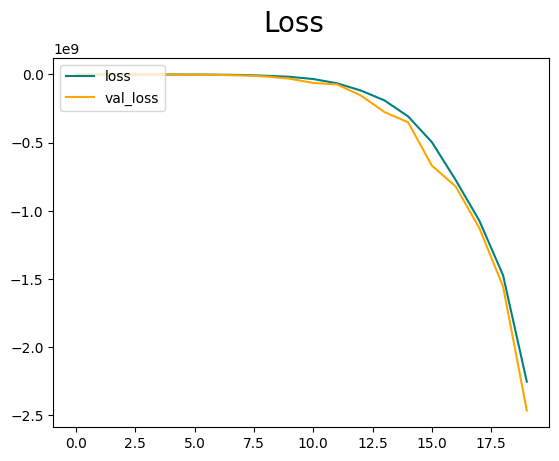

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

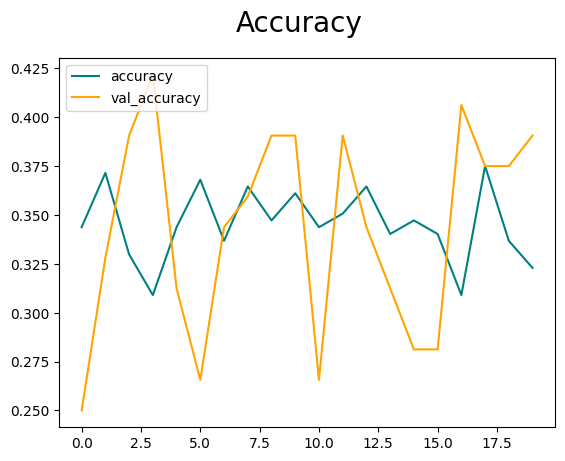

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 262ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.84375, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.21875, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

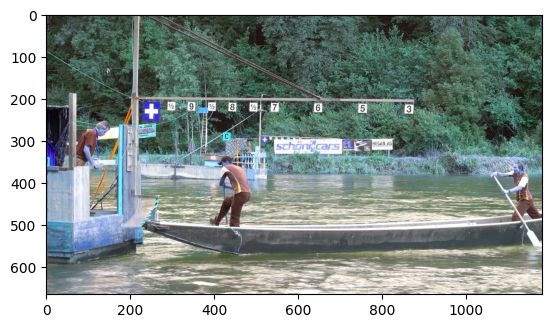

In [36]:
img = cv2.imread('G:/Ponti/pfeiler/8bc9a1d9-11a8-467c-8060-09ba63162546.jpg')
plt.imshow(img)
plt.show()

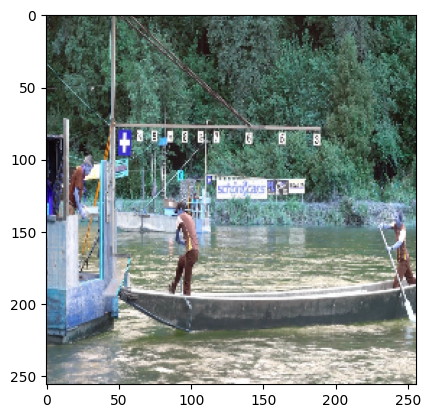

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 73ms/step


In [39]:
yhat

array([[1.]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')
print(yhat)

Predicted class is Sad
[[1.]]


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)